# Combined labels for both cells and nuclei for skin_s4
# Version with late fusion PCA

In [1]:
slide_id = "skin_s4"

In [2]:
import pandas as pd
import scanpy as sc
import spatialdata as sd
import numpy as np
import anndata as ad
from spatialdata.models import get_table_keys
from matplotlib.colors import to_rgba
from functools import partial
from matplotlib import colors

## 1. Load the data

In [3]:
sdata_processed = sd.read_zarr(f"/Volumes/DD_FGS/MICS/data_HE2CellType/CT_DS/sdata_processed/sdata_{slide_id}.zarr", selection=('tables',))
sdata_processed

/Users/felicie-giraud-sauveur/miniforge3/envs/cluster/lib/python3.10/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)
/Users/felicie-giraud-sauveur/miniforge3/envs/cluster/lib/python3.10/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is annotating 'nucleus_boundaries', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)


SpatialData object, with associated Zarr store: /Volumes/DD_FGS/MICS/data_HE2CellType/CT_DS/sdata_processed/sdata_skin_s4.zarr
└── Tables
      ├── 'table_cells': AnnData (109795, 5006)
      └── 'table_nuclei': AnnData (109795, 7638)
with coordinate systems:

with the following elements in the Zarr store but not in the SpatialData object:
    ▸ he (Images)
    ▸ morpho (Images)
    ▸ st (Points)
    ▸ nucleus_boundaries (Shapes)
    ▸ cell_boundaries (Shapes)

In [4]:
adata_nuclei_ini = sdata_processed.tables['table_nuclei'].copy()
adata_nuclei_ini

AnnData object with n_obs × n_vars = 109795 × 7638
    obs: 'region', 'slide', 'cell_id', 'area', 'ct_tangram'
    uns: 'sopa_attrs', 'spatialdata_attrs'
    obsm: 'spatial', 'tangram_pred'

In [5]:
adata_nuclei_ini.var

""
A2ML1
AAMP
AAR2
AARSD1
ABAT
...
ZSCAN26
ZSWIM6
ZUP1
ZYG11B


In [6]:
adata_cells_ini = sdata_processed.tables['table_cells'].copy()
adata_cells_ini

AnnData object with n_obs × n_vars = 109795 × 5006
    obs: 'cell_id', 'transcript_counts', 'control_probe_counts', 'genomic_control_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'nucleus_count', 'segmentation_method', 'region', 'z_level'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatialdata_attrs'
    obsm: 'spatial'

In [7]:
adata_cells_ini.var

,gene_ids,feature_types,genome
A2ML1,ENSG00000166535,Gene Expression,Unknown
AAMP,ENSG00000127837,Gene Expression,Unknown
AAR2,ENSG00000131043,Gene Expression,Unknown
AARSD1,ENSG00000266967,Gene Expression,Unknown
ABAT,ENSG00000183044,Gene Expression,Unknown
...,...,...,...
ZSCAN26,ENSG00000197062,Gene Expression,Unknown
ZSWIM6,ENSG00000130449,Gene Expression,Unknown
ZUP1,ENSG00000153975,Gene Expression,Unknown
ZYG11B,ENSG00000162378,Gene Expression,Unknown


## 2. Get adata_nuclei and adata_cyto

In [8]:
adata_cells_ini = adata_cells_ini[adata_cells_ini.obs["transcript_counts"]>10].copy()  # Filter cells with less than 10 transcripts
len(adata_cells_ini.obs)

106783

In [9]:
# Align the cell_id in both AnnData objects
# Create a mapping of cell_id to index position in both objects
nuclei_idx = adata_nuclei_ini.obs.set_index('cell_id').index
cells_idx = adata_cells_ini.obs.set_index('cell_id').index

# Find the intersection of cell_id in both datasets
common_cells = nuclei_idx.intersection(cells_idx)
print(f"Number of common cell_ids: {len(common_cells)}")

# Subset both AnnData objects to include only common cell_ids
adata_nuclei = adata_nuclei_ini[adata_nuclei_ini.obs['cell_id'].isin(common_cells)]
adata_cells = adata_cells_ini[adata_cells_ini.obs['cell_id'].isin(common_cells)]

# Merge the 'obs' dataframes based on 'cell_id' to ensure the same order in both
obs_nuclei = adata_nuclei.obs[['cell_id']].reset_index(drop=True)
obs_cells = adata_cells.obs[['cell_id']].reset_index(drop=True)

# Ensure that both are in the same order
adata_nuclei = adata_nuclei[obs_nuclei['cell_id'].argsort().values]
adata_cells = adata_cells[obs_cells['cell_id'].argsort().values]

# Check that the cell_ids match now
assert np.array_equal(adata_nuclei.obs['cell_id'].values, adata_cells.obs['cell_id'].values), "Cell IDs do not match after alignment."

# Find common genes
common_genes = adata_nuclei.var_names.intersection(adata_cells.var_names)
print(f"Number of common genes: {len(common_genes)}")

# Subset both AnnData objects to include only the common genes
adata_nuclei = adata_nuclei[:, common_genes]
adata_cells = adata_cells[:, common_genes]

# Remove nucleus RNA from cell RNA to get the cytoplasmic RNA
X_cyto = adata_cells.X - adata_nuclei.X

# Because of slight mismatches or rounding, some entries might go negative by 1 or 2 in real data. So we clip to 0:
X_cyto.data = np.clip(X_cyto.data, a_min=0, a_max=None)

# Create a new AnnData object with the cytoplasmic RNA
adata_cyto = ad.AnnData(
    X=X_cyto,
    obs=adata_cells.obs.copy(),  # or adata_nuclei.obs, they should be the same set
    var=adata_cells.var.copy()   # same genes as well
)

Number of common cell_ids: 106783
Number of common genes: 4992


In [10]:
adata_nuclei.obs["transcript_counts"] = adata_nuclei.X.sum(axis=1)
adata_nuclei.obs

/var/folders/ff/llzyqd_s78v1k8vywvjxp5_r0000gn/T/ipykernel_41755/547616959.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_nuclei.obs["transcript_counts"] = adata_nuclei.X.sum(axis=1)


,region,slide,cell_id,area,ct_tangram,transcript_counts
aaaaaaaa-1,nucleus_boundaries,morpho,aaaaaaaa-1,67.711847,Arterial EC,567
aaaaaaab-1,nucleus_boundaries,morpho,aaaaaaab-1,55.994183,Spinous keratinocyte,1046
aaaaaaac-1,nucleus_boundaries,morpho,aaaaaaac-1,41.317727,Spinous keratinocyte,578
aaaaaaad-1,nucleus_boundaries,morpho,aaaaaaad-1,12.508198,Arterial EC,88
aaaaaaae-1,nucleus_boundaries,morpho,aaaaaaae-1,41.024334,Granular keratinocyte,254
...,...,...,...,...,...,...
aaabkmnm-1,nucleus_boundaries,morpho,aaabkmnm-1,7.293094,Merkel cell carcinoma enriched epithelial cell,9
aaabkmnn-1,nucleus_boundaries,morpho,aaabkmnn-1,13.480007,Memory B,36
aaabkmno-1,nucleus_boundaries,morpho,aaabkmno-1,5.418354,Merkel cell carcinoma enriched epithelial cell,15
aaabkmob-1,nucleus_boundaries,morpho,aaabkmob-1,26.145439,NK cell,94


In [11]:
adata_cyto.obs["transcript_counts"] = adata_cyto.X.sum(axis=1).astype(int)
adata_cyto.obs

,cell_id,transcript_counts,control_probe_counts,genomic_control_counts,control_codeword_counts,unassigned_codeword_counts,deprecated_codeword_counts,total_counts,cell_area,nucleus_area,nucleus_count,segmentation_method,region,z_level
0,aaaaaaaa-1,1904,0,0,0,0,30,2475,489.719549,70.082503,1.0,Segmented by boundary stain (ATP1A1+CD45+E-Cad...,cell_labels,0.0
1,aaaaaaab-1,1681,0,1,0,0,16,2675,333.162825,58.522502,1.0,Segmented by boundary stain (ATP1A1+CD45+E-Cad...,cell_labels,0.0
2,aaaaaaac-1,1201,0,0,0,0,8,1755,254.274853,43.485470,1.0,Segmented by boundary stain (ATP1A1+CD45+E-Cad...,cell_labels,0.0
3,aaaaaaad-1,1794,0,0,0,1,33,1911,332.666106,13.908126,1.0,Segmented by boundary stain (ATP1A1+CD45+E-Cad...,cell_labels,0.0
9,aaaaaaae-1,826,0,0,0,0,11,1086,199.184226,43.124220,1.0,Segmented by boundary stain (ATP1A1+CD45+E-Cad...,cell_labels,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112544,aaabkmnm-1,3,0,0,0,0,0,11,8.308750,8.308750,1.0,Segmented by nucleus expansion of 5.0µm,cell_labels,4.0
112545,aaabkmnn-1,8,0,0,0,0,0,42,18.785001,14.901563,1.0,Segmented by nucleus expansion of 5.0µm,cell_labels,5.0
112546,aaabkmno-1,1,0,0,0,0,0,16,6.276719,6.276719,1.0,Segmented by nucleus expansion of 5.0µm,cell_labels,4.0
112549,aaabkmob-1,59,0,0,0,0,0,139,65.115315,27.816251,1.0,Segmented by nucleus expansion of 5.0µm,cell_labels,5.0


In [12]:
adata_cells_ini.obs

,cell_id,transcript_counts,control_probe_counts,genomic_control_counts,control_codeword_counts,unassigned_codeword_counts,deprecated_codeword_counts,total_counts,cell_area,nucleus_area,nucleus_count,segmentation_method,region,z_level
0,aaaaaaaa-1,2445,0,0,0,0,30,2475,489.719549,70.082503,1.0,Segmented by boundary stain (ATP1A1+CD45+E-Cad...,cell_labels,0.0
1,aaaaaaab-1,2658,0,1,0,0,16,2675,333.162825,58.522502,1.0,Segmented by boundary stain (ATP1A1+CD45+E-Cad...,cell_labels,0.0
2,aaaaaaac-1,1747,0,0,0,0,8,1755,254.274853,43.485470,1.0,Segmented by boundary stain (ATP1A1+CD45+E-Cad...,cell_labels,0.0
3,aaaaaaad-1,1877,0,0,0,1,33,1911,332.666106,13.908126,1.0,Segmented by boundary stain (ATP1A1+CD45+E-Cad...,cell_labels,0.0
9,aaaaaaae-1,1075,0,0,0,0,11,1086,199.184226,43.124220,1.0,Segmented by boundary stain (ATP1A1+CD45+E-Cad...,cell_labels,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112544,aaabkmnm-1,11,0,0,0,0,0,11,8.308750,8.308750,1.0,Segmented by nucleus expansion of 5.0µm,cell_labels,4.0
112545,aaabkmnn-1,42,0,0,0,0,0,42,18.785001,14.901563,1.0,Segmented by nucleus expansion of 5.0µm,cell_labels,5.0
112546,aaabkmno-1,16,0,0,0,0,0,16,6.276719,6.276719,1.0,Segmented by nucleus expansion of 5.0µm,cell_labels,4.0
112549,aaabkmob-1,139,0,0,0,0,0,139,65.115315,27.816251,1.0,Segmented by nucleus expansion of 5.0µm,cell_labels,5.0


In [13]:
adata_nuclei.var

""
A2ML1
AAMP
AAR2
AARSD1
ABAT
...
ZSCAN26
ZSWIM6
ZUP1
ZYG11B


In [14]:
adata_cyto.var

,gene_ids,feature_types,genome
A2ML1,ENSG00000166535,Gene Expression,Unknown
AAMP,ENSG00000127837,Gene Expression,Unknown
AAR2,ENSG00000131043,Gene Expression,Unknown
AARSD1,ENSG00000266967,Gene Expression,Unknown
ABAT,ENSG00000183044,Gene Expression,Unknown
...,...,...,...
ZSCAN26,ENSG00000197062,Gene Expression,Unknown
ZSWIM6,ENSG00000130449,Gene Expression,Unknown
ZUP1,ENSG00000153975,Gene Expression,Unknown
ZYG11B,ENSG00000162378,Gene Expression,Unknown


## 3. Separated PCA

In [15]:
# Preprocess the data

sc.pp.normalize_total(adata_nuclei, target_sum=1e4)
sc.pp.log1p(adata_nuclei)

sc.pp.normalize_total(adata_cyto, target_sum=1e4)
sc.pp.log1p(adata_cyto)

/Users/felicie-giraud-sauveur/miniforge3/envs/cluster/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:234: UserWarning: Some cells have zero counts
  warn(UserWarning("Some cells have zero counts"))


In [16]:
# Scale each gene to unit variance. Clip values exceeding standard deviation 10.
sc.pp.scale(adata_nuclei, max_value=10)
sc.pp.scale(adata_cyto, max_value=10)

In [17]:
# Reduce the dimensionality of the data by running principal component analysis (PCA), which reveals the main axes of variation and denoises the data.
sc.tl.pca(adata_nuclei, svd_solver="arpack", use_highly_variable=False)
sc.tl.pca(adata_cyto, svd_solver="arpack", use_highly_variable=False)

/Users/felicie-giraud-sauveur/miniforge3/envs/cluster/lib/python3.10/site-packages/scanpy/preprocessing/_pca.py:385: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  warn(msg, FutureWarning)
/Users/felicie-giraud-sauveur/miniforge3/envs/cluster/lib/python3.10/site-packages/scanpy/preprocessing/_pca.py:385: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  warn(msg, FutureWarning)


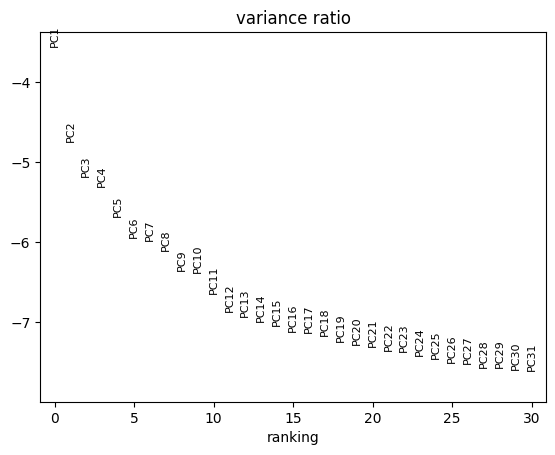

In [18]:
# Contribution of single PCs to the total variance in the data
# This gives us information about how many PCs we should consider in order to compute the neighborhood relations of cells, e.g. used in the clustering function  `sc.tl.louvain()` or tSNE `sc.tl.tsne()`
sc.pl.pca_variance_ratio(adata_nuclei, log=True)

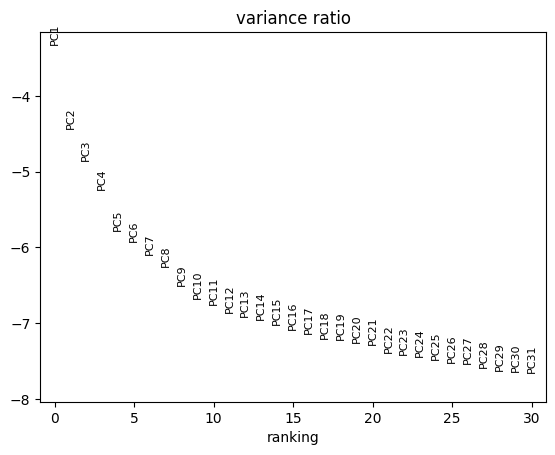

In [19]:
sc.pl.pca_variance_ratio(adata_cyto, log=True)

In [ ]:
adata_nuclei

In [ ]:
adata_cyto

In [20]:
# Group the PCs into a single AnnData object
X_nuc_pca = adata_nuclei.obsm["X_pca"][:, :21]
X_cyto_pca = adata_cyto.obsm["X_pca"][:, :21]

# As in MFA, divide the PCs by the square root of the maximal eigenvalue for each dataset separately
X_nuc_pca /= np.sqrt(np.max(adata_nuclei.uns["pca"]["variance"]))
X_cyto_pca /= np.sqrt(np.max(adata_cyto.uns["pca"]["variance"]))

# Check that obs_names align
assert np.array_equal(adata_nuclei.obs['cell_id'].values, adata_cyto.obs['cell_id'].values), "Cell IDs do not match"

# Concatenate along columns (features) and keep only informative PCs
X_combined = np.concatenate([X_nuc_pca, X_cyto_pca], axis=1)

# Create a new AnnData to store these fused PCs
adata_combined = ad.AnnData(X=X_combined, obs=adata_nuclei.obs.copy())

# Name the columns
adata_combined.var_names = [f"PC_nuc_{i}" for i in range(len(X_nuc_pca[0]))] + [f"PC_cyto_{i}" for i in range(len(X_cyto_pca[0]))]

In [21]:
# Check var of first PC for each table is 1
print(np.var(adata_nuclei.obsm["X_pca"][:, 0]))
print(np.var(adata_cyto.obsm["X_pca"][:, 0]))

0.99999064
0.9999907


In [22]:
# Have a look to all the PCs var in the combined data
print("Nuc:")
for i in range(21):
    print(f"PC {i} variance: {np.var(adata_nuclei.obsm['X_pca'][:, i])}")
print("Cyto:")
for i in range(21):
    print(f"PC {i} variance: {np.var(adata_cyto.obsm['X_pca'][:, i])}")

Nuc:
PC 0 variance: 0.9999906420707703
PC 1 variance: 0.30401885509490967
PC 2 variance: 0.19581501185894012
PC 3 variance: 0.1729131042957306
PC 4 variance: 0.11944220960140228
PC 5 variance: 0.09164991974830627
PC 6 variance: 0.08843594789505005
PC 7 variance: 0.07745277136564255
PC 8 variance: 0.06087715923786163
PC 9 variance: 0.05895489826798439
PC 10 variance: 0.04537303000688553
PC 11 variance: 0.0360676534473896
PC 12 variance: 0.03404756635427475
PC 13 variance: 0.03213139623403549
PC 14 variance: 0.030636731535196304
PC 15 variance: 0.02832873724400997
PC 16 variance: 0.02774716354906559
PC 17 variance: 0.026869291439652443
PC 18 variance: 0.024891840294003487
PC 19 variance: 0.024174297228455544
PC 20 variance: 0.0233746487647295
Cyto:
PC 0 variance: 0.999990701675415
PC 1 variance: 0.32813748717308044
PC 2 variance: 0.21485470235347748
PC 3 variance: 0.14785711467266083
PC 4 variance: 0.08599818497896194
PC 5 variance: 0.0735178142786026
PC 6 variance: 0.06233864650130272
P

In [23]:
# Add final labels coming from table nuclei and table cells

sdata_final = sd.read_zarr(f"/Volumes/DD_FGS/MICS/data_HE2CellType/CT_DS/sdata_final/sdata_{slide_id}.zarr", selection=('tables', 'shapes'))

cellid2transcript_cat = dict(sdata_final.tables['table_cells'].obs[['cell_id', 'transcript_cat']].values)

cellid2nucleilabel = dict(sdata_final.tables['table_nuclei'].obs[['cell_id', 'final_label']].values)
cellid2celllabel = dict(sdata_final.tables['table_cells'].obs[['cell_id', 'final_label']].values)

cellid2nucleilabel1 = dict(sdata_final.tables['table_nuclei'].obs[['cell_id', 'label1']].values)
cellid2celllabel1 = dict(sdata_final.tables['table_cells'].obs[['cell_id', 'label1']].values)

adata_combined.obs['transcript_cat'] = adata_combined.obs['cell_id'].map(cellid2transcript_cat).fillna('Unknown')

adata_combined.obs['final_label_nuclei'] = adata_combined.obs['cell_id'].map(cellid2nucleilabel).fillna('Unknown')
adata_combined.obs['final_label_cells'] = adata_combined.obs['cell_id'].map(cellid2celllabel).fillna('Unknown')

adata_combined.obs['label1_nuclei'] = adata_combined.obs['cell_id'].map(cellid2nucleilabel1).fillna('Unknown')
adata_combined.obs['label1_cells'] = adata_combined.obs['cell_id'].map(cellid2celllabel1).fillna('Unknown')

adata_combined.obs

,region,slide,cell_id,area,ct_tangram,transcript_counts,transcript_cat,final_label_nuclei,final_label_cells,label1_nuclei,label1_cells
aaaaaaaa-1,nucleus_boundaries,morpho,aaaaaaaa-1,67.711847,Arterial EC,567,6,Epithelial,Epithelial,Keratinocyte,Epithelial
aaaaaaab-1,nucleus_boundaries,morpho,aaaaaaab-1,55.994183,Spinous keratinocyte,1046,6,Epithelial,Epithelial,Keratinocyte,Epithelial
aaaaaaac-1,nucleus_boundaries,morpho,aaaaaaac-1,41.317727,Spinous keratinocyte,578,6,Epithelial,Epithelial,Keratinocyte,Epithelial
aaaaaaad-1,nucleus_boundaries,morpho,aaaaaaad-1,12.508198,Arterial EC,88,6,Epithelial,Epithelial,Keratinocyte,Epithelial
aaaaaaae-1,nucleus_boundaries,morpho,aaaaaaae-1,41.024334,Granular keratinocyte,254,6,Epithelial,Epithelial,Keratinocyte,Epithelial
...,...,...,...,...,...,...,...,...,...,...,...
aaabkmnm-1,nucleus_boundaries,morpho,aaabkmnm-1,7.293094,Merkel cell carcinoma enriched epithelial cell,9,0,Less10,Unknown,less10,Unknown
aaabkmnn-1,nucleus_boundaries,morpho,aaabkmnn-1,13.480007,Memory B,36,0,T_NK,Unknown,T,Unknown
aaabkmno-1,nucleus_boundaries,morpho,aaabkmno-1,5.418354,Merkel cell carcinoma enriched epithelial cell,15,0,Stem_like,Stem_like,Cancer_stem_like_cells,Stem_like_cell
aaabkmob-1,nucleus_boundaries,morpho,aaabkmob-1,26.145439,NK cell,94,1,T_NK,T_NK,T,T


In [24]:
adata_combined

AnnData object with n_obs × n_vars = 106783 × 42
    obs: 'region', 'slide', 'cell_id', 'area', 'ct_tangram', 'transcript_counts', 'transcript_cat', 'final_label_nuclei', 'final_label_cells', 'label1_nuclei', 'label1_cells'

In [25]:
adata_combined.var

""
PC_nuc_0
PC_nuc_1
PC_nuc_2
PC_nuc_3
PC_nuc_4
PC_nuc_5
PC_nuc_6
PC_nuc_7
PC_nuc_8
PC_nuc_9


## 4. PCA on the two separated PCA (late fusion) + Clustering

In [26]:
# Run a "second PCA" on the scaled features
# No scaling because we already scaled using the maximum eigenvalue for each table
sc.tl.pca(adata_combined)

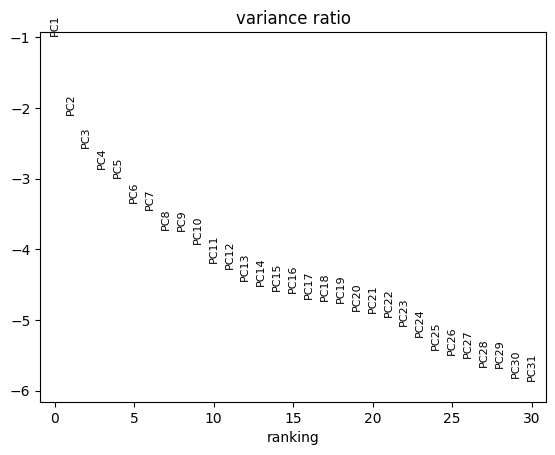

In [27]:
sc.pl.pca_variance_ratio(adata_combined, log=True)

In [28]:
adata_combined

AnnData object with n_obs × n_vars = 106783 × 42
    obs: 'region', 'slide', 'cell_id', 'area', 'ct_tangram', 'transcript_counts', 'transcript_cat', 'final_label_nuclei', 'final_label_cells', 'label1_nuclei', 'label1_cells'
    uns: 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

In [29]:
# Neighborhood graph of cells using the PCA representation of the data matrix
sc.pp.neighbors(adata_combined, n_neighbors=10, n_pcs=31, use_rep="X_pca", key_added='pca_n10_pcs31')
# Embedding the neighborhood graph using UMAP
sc.tl.umap(adata_combined, neighbors_key='pca_n10_pcs31')
# Leiden clustering directly clusters the neighborhood graph of cells
sc.tl.leiden(adata_combined, resolution=0.4, random_state=0, n_iterations=2, directed=False, key_added='pca_n10_pcs31_leiden_res0.4', neighbors_key='pca_n10_pcs31')
sc.tl.leiden(adata_combined, resolution=0.6, random_state=0, n_iterations=2, directed=False, key_added='pca_n10_pcs31_leiden_res0.6', neighbors_key='pca_n10_pcs31')

/Users/felicie-giraud-sauveur/miniforge3/envs/cluster/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/var/folders/ff/llzyqd_s78v1k8vywvjxp5_r0000gn/T/ipykernel_41755/1382934791.py:6: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata_combined, resolution=0.4, random_state=0, n_iterations=2, directed=False, key_added='pca_n10_pcs31_leiden_res0.4', neighbors_key='pca_n10_pcs31')


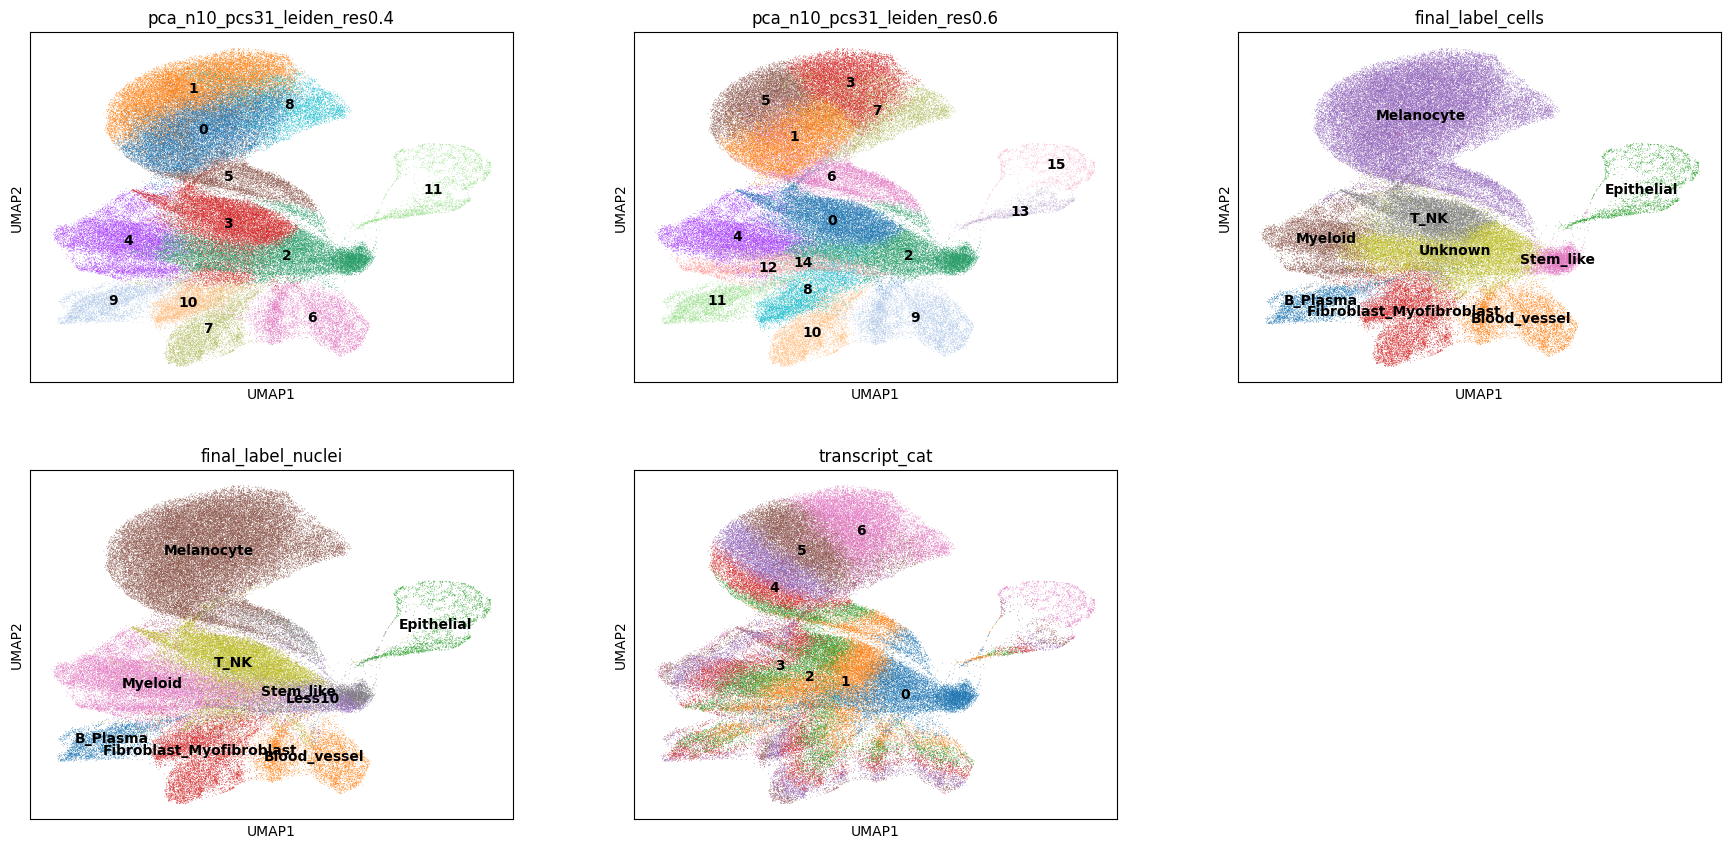

In [30]:
# Plot the clusters
adata_combined.obs['transcript_cat'] = pd.Categorical(adata_combined.obs['transcript_cat'])
sc.pl.umap(adata_combined, neighbors_key='pca_n10_pcs31',
           color=['pca_n10_pcs31_leiden_res0.4', 'pca_n10_pcs31_leiden_res0.6', 'final_label_cells', 'final_label_nuclei', 'transcript_cat'],
           ncols=3, legend_loc='on data')

In [31]:
clustering_label = 'pca_n10_pcs31_leiden_res0.6'

In [32]:
# Put the clustering_label into the adata_cells to be able to use marker genes, and also final_label_cells and final_label_nuclei
cellid2clustering_label = dict(adata_combined.obs[['cell_id', clustering_label]].values)
adata_cells.obs["cluster_combined"] = adata_cells.obs['cell_id'].map(cellid2clustering_label).fillna('Unknown')
adata_cells.obs["final_label_cells"] = adata_cells.obs['cell_id'].map(cellid2celllabel).fillna('Unknown')
adata_cells.obs["final_label_nuclei"] = adata_cells.obs['cell_id'].map(cellid2nucleilabel).fillna('Unknown')


# Preprocess the adata_cells
sc.pp.normalize_total(adata_cells, target_sum=1e4)
sc.pp.log1p(adata_cells)

# Add X_umap to adata_cells, checking before cell_id alignment
assert np.array_equal(adata_cells.obs['cell_id'].values, adata_combined.obs['cell_id'].values), "Cell IDs do not match"
adata_cells.obsm['X_umap'] = adata_combined.obsm['X_umap']

# Wilcoxon rank-sum (Mann-Whitney-U) test. 
# You might also consider much more powerful differential testing packages like MAST, limma, DESeq2 and, for python, the recent diffxpy.
sc.tl.rank_genes_groups(adata_cells, "cluster_combined", method="wilcoxon", corr_method="benjamini-hochberg", key_added="rank_genes_"+"cluster_combined")
# The top ranked genes per cluster
top_ranked_genes = pd.DataFrame(adata_cells.uns["rank_genes_"+"cluster_combined"]["names"]).iloc[:7, :]
list_genes = pd.concat([top_ranked_genes[col] for col in top_ranked_genes], ignore_index=True).tolist()

/var/folders/ff/llzyqd_s78v1k8vywvjxp5_r0000gn/T/ipykernel_41755/4236311698.py:3: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_cells.obs["cluster_combined"] = adata_cells.obs['cell_id'].map(cellid2clustering_label).fillna('Unknown')


## 5. Analyze and get combined labels

### Helper functions

In [33]:
def analyze_clusters(adata, resolution_key):
    
    # Ensure the resolution key exists in obs
    if resolution_key not in adata.obs:
        raise ValueError(f"{resolution_key} not found in adata.obs.")
    
    # Group data by the specified clustering resolution
    cluster_groups = adata.obs.groupby(resolution_key)

    results = {}

    for cluster_id, group in cluster_groups:
        
        # Calculate dominant labels for final_label_cells
        label_cells_counts = group['final_label_cells'].value_counts(normalize=True)
        dominant_cells = label_cells_counts.head(2) * 100  # Get top 2 labels as percentages

        # Calculate top1 for label1 for cells
        label1_cells_counts = group['label1_cells'].value_counts(normalize=True)
        top1_cells = label1_cells_counts.head(1) * 100

        # Calculate dominant labels for final_label_nuclei
        label_nuclei_counts = group['final_label_nuclei'].value_counts(normalize=True)
        dominant_nuclei = label_nuclei_counts.head(2) * 100  # Get top 2 labels as percentages

        # Calculate top1 for label1 for nuclei
        label1_nuclei_counts = group['label1_nuclei'].value_counts(normalize=True)
        top1_nuclei = label1_nuclei_counts.head(1) * 100
        if top1_nuclei.keys()[0] == 'less_10_rna':
            top1_nuclei = label1_nuclei_counts.head(2).tail(1) * 100
        
        # Align categories for comparison
        common_categories = group['final_label_cells'].cat.categories.union(group['final_label_nuclei'].cat.categories)
        group['final_label_cells'] = group['final_label_cells'].cat.set_categories(common_categories)
        group['final_label_nuclei'] = group['final_label_nuclei'].cat.set_categories(common_categories)

        # Count different labels between final_label_cells and final_label_nuclei
        total_cells = len(group)  # Total number of cells in the cluster
        differing_labels_count_woUnknown = ((group['final_label_cells'] != group['final_label_nuclei']) & (group['final_label_nuclei'] != 'Unknown')  & (group['final_label_nuclei'] != 'Less10')).sum() / total_cells * 100
        differing_labels_count = (group['final_label_cells'] != group['final_label_nuclei']).sum() / total_cells * 100

        # Store the results
        results[cluster_id] = (dominant_cells.to_dict(), dominant_nuclei.to_dict(), top1_cells.to_dict(), top1_nuclei.to_dict(), differing_labels_count_woUnknown, differing_labels_count)

    return results

In [34]:
def analyze_cluster_dominance(cluster_analysis_results):
    
    clusters_unknown_cells = []
    clusters_different_top1 = []
    clusters_high_diff = []

    for cluster_id, (dominant_cells, dominant_nuclei, label1_cells, label1_nuclei, diff_percentage_woUnknown, _) in cluster_analysis_results.items():
        
        # Check if top 1 dominant_cells is 'Unknown' or 'Less10'
        
        top1_dominant_cells = max(dominant_cells, key=dominant_cells.get)
        if top1_dominant_cells == 'Unknown' or top1_dominant_cells == 'Less10':
            clusters_unknown_cells.append(cluster_id)
        
        # Check if top 1 for dominant_cells is different from dominant_nuclei
        
        top1_dominant_nuclei = max(dominant_nuclei, key=dominant_nuclei.get)

        if top1_dominant_nuclei == 'Unknown' or top1_dominant_nuclei == 'Less10':
            sorted_nuclei = sorted(dominant_nuclei.items(), key=lambda x: x[1], reverse=True)
            if len(sorted_nuclei) > 1:  # Make sure there's a second element
                top1_dominant_nuclei = sorted_nuclei[1][0]

        if top1_dominant_cells != top1_dominant_nuclei:
            clusters_different_top1.append(cluster_id)
        
        # Check if diff_percentage_woUnknown is greater than 40%
        
        if diff_percentage_woUnknown > 40:
            clusters_high_diff.append(cluster_id)

    print(f"Clusters where the top 1 for dominant_cells is 'Unknown' or 'Less10': {clusters_unknown_cells}")
    print(f"Clusters where the top 1 for dominant_cells differs from dominant_nuclei (excluding 'Unknown' and 'Less10'): {clusters_different_top1}")
    print(f"Clusters where diff_percentage_woUnknown is greater than 40%: {clusters_high_diff}")

    print("=" * 50)

    clusters_to_analyse = set(clusters_unknown_cells + clusters_different_top1 + clusters_high_diff)
    for cluster_id in clusters_to_analyse:
        print(f"\nCluster ID: {cluster_id}")
        print(f"Dominant final_label_cells: {cluster_analysis_results[cluster_id][0]} - with dominant label1: {cluster_analysis_results[cluster_id][2]}")
        print(f"Dominant final_label_nuclei: {cluster_analysis_results[cluster_id][1]} - with dominant label1: {cluster_analysis_results[cluster_id][3]}")
        print(f"Count of differing labels without 'Unknown' or 'Less10' label for Nuclei: {round(cluster_analysis_results[cluster_id][4], 2)} %")
        print(f"Count of differing labels: {round(cluster_analysis_results[cluster_id][5], 2)} %")
        print(f"% of cells in cluster: {round(len(adata_combined.obs[adata_combined.obs[clustering_label] == cluster_id]) / len(adata_combined.obs) * 100, 2)} %")
        print("-----")

In [35]:
def assign_final_labels(cluster_analysis_results, input_dict):
    
    dict_combined_labels = {}

    for cluster_id, (dominant_cells, _, _, _, _, _) in cluster_analysis_results.items():
        
        if cluster_id in input_dict:
            # Use the label from input_dict if cluster_id is in it
            dict_combined_labels[cluster_id] = input_dict[cluster_id]
        else:
            # Otherwise, use the dominant label from final_label_cells
            dict_combined_labels[cluster_id] = max(dominant_cells, key=dominant_cells.get)

    return dict_combined_labels

### Analysis

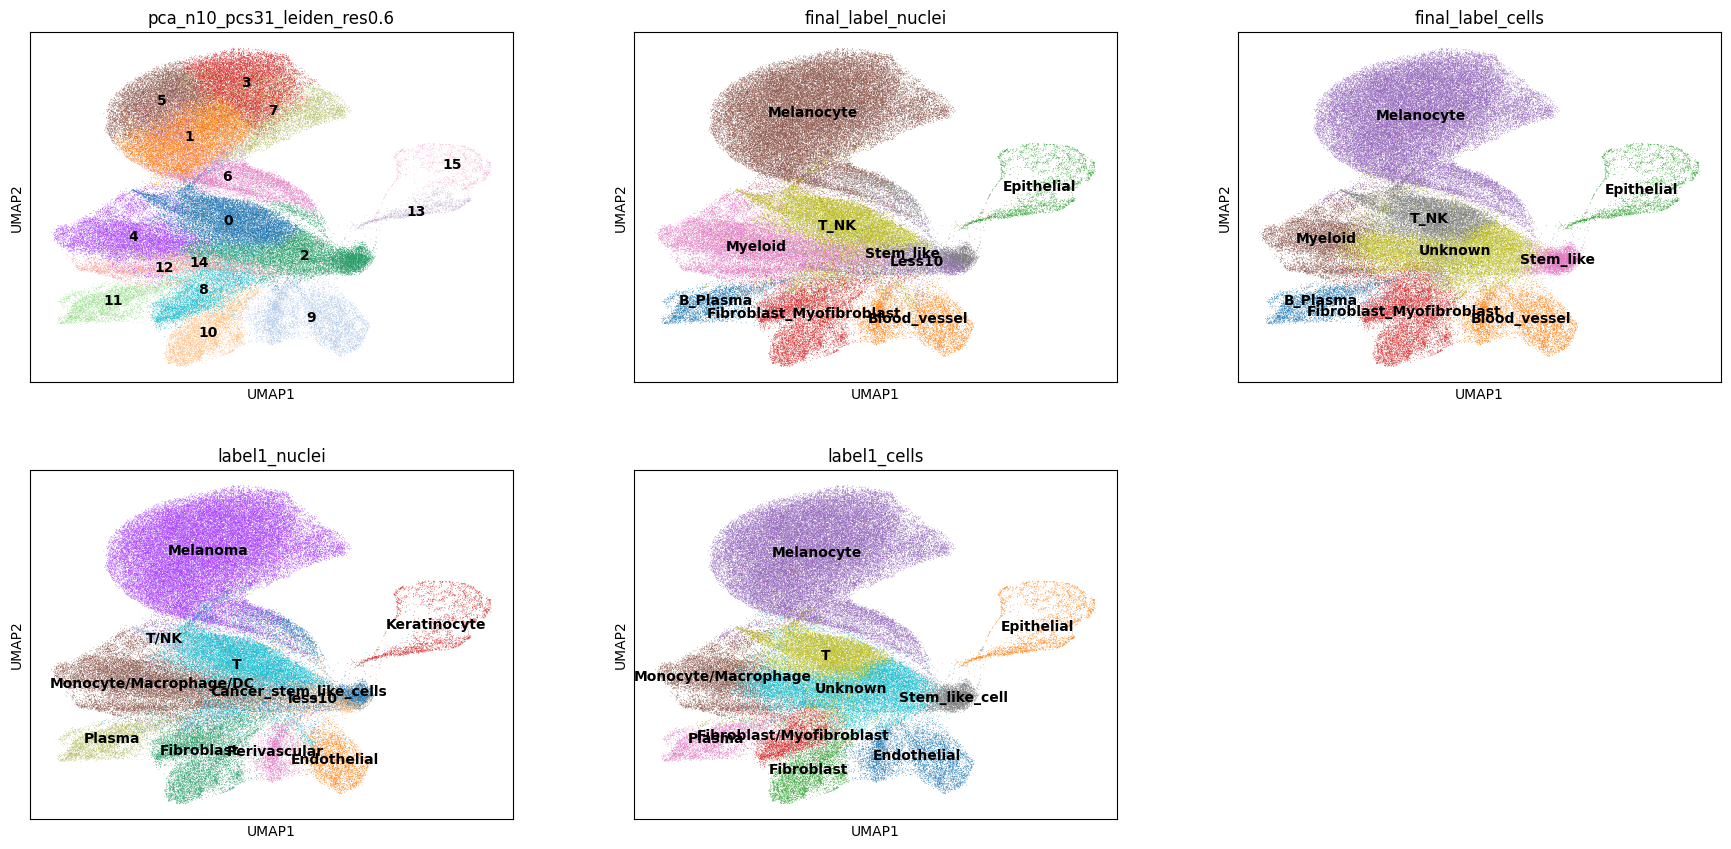

In [36]:
# Plot the clusters
sc.pl.umap(adata_combined, neighbors_key='pca_n10_pcs31',
           color=[clustering_label, 'final_label_nuclei', 'final_label_cells', 'label1_nuclei', 'label1_cells'],
           ncols=3, legend_loc='on data')

In [37]:
cluster_analysis_results = analyze_clusters(adata_combined, clustering_label)

for cluster_id, (dominant_cells, dominant_nuclei, _, _, diff_count_woUnknown, diff_count) in cluster_analysis_results.items():
    print("=" * 50)
    print(f"Cluster ID: {cluster_id}")
    print(f"Dominant final_label_cells: {dominant_cells}")
    print(f"Dominant final_label_nuclei: {dominant_nuclei}")
    print(f"Count of differing labels without 'Unknown/Less10' label for Nuclei: {round(diff_count_woUnknown, 2)} %")
    print(f"Count of differing labels: {round(diff_count, 2)} %\n")

Cluster ID: 0
Dominant final_label_cells: {'T_NK': 78.96111879514369, 'Unknown': 18.89503611495313}
Dominant final_label_nuclei: {'T_NK': 93.23805132933764, 'Myeloid': 3.234977716305517}
Count of differing labels without 'Unknown/Less10' label for Nuclei: 23.2 %
Count of differing labels: 23.74 %

Cluster ID: 1
Dominant final_label_cells: {'Melanocyte': 98.43986309002626, 'T_NK': 0.6925097508556873}
Dominant final_label_nuclei: {'Melanocyte': 98.72641884900104, 'T_NK': 0.48555281381835547}
Count of differing labels without 'Unknown/Less10' label for Nuclei: 2.2 %
Count of differing labels: 2.2 %

Cluster ID: 2
Dominant final_label_cells: {'Unknown': 61.22522522522522, 'Stem_like': 33.00900900900901}
Dominant final_label_nuclei: {'Stem_like': 36.693693693693696, 'Less10': 24.36036036036036}
Count of differing labels without 'Unknown/Less10' label for Nuclei: 54.35 %
Count of differing labels: 78.71 %

Cluster ID: 3
Dominant final_label_cells: {'Melanocyte': 99.945180447693, 'Fibroblast_

/var/folders/ff/llzyqd_s78v1k8vywvjxp5_r0000gn/T/ipykernel_41755/1125182952.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cluster_groups = adata.obs.groupby(resolution_key)


In [38]:
analyze_cluster_dominance(cluster_analysis_results)

Clusters where the top 1 for dominant_cells is 'Unknown' or 'Less10': ['2', '12', '14']
Clusters where the top 1 for dominant_cells differs from dominant_nuclei (excluding 'Unknown' and 'Less10'): ['2', '12', '14']
Clusters where diff_percentage_woUnknown is greater than 40%: ['2', '12', '14']

Cluster ID: 2
Dominant final_label_cells: {'Unknown': 61.22522522522522, 'Stem_like': 33.00900900900901} - with dominant label1: {'Unknown': 61.22522522522522}
Dominant final_label_nuclei: {'Stem_like': 36.693693693693696, 'Less10': 24.36036036036036} - with dominant label1: {'Cancer_stem_like_cells': 36.693693693693696}
Count of differing labels without 'Unknown' or 'Less10' label for Nuclei: 54.35 %
Count of differing labels: 78.71 %
% of cells in cluster: 10.39 %
-----

Cluster ID: 14
Dominant final_label_cells: {'Unknown': 91.46810146041506, 'Myeloid': 8.147578785549578} - with dominant label1: {'Unknown': 91.46810146041506}
Dominant final_label_nuclei: {'Myeloid': 62.41352805534205, 'Stem_l

In [39]:
dict_combined_labels = assign_final_labels(cluster_analysis_results, {'2':'Unknown', '12':'Myeloid', '14':'Myeloid'})
dict_combined_labels

{'0': 'T_NK',
 '1': 'Melanocyte',
 '2': 'Unknown',
 '3': 'Melanocyte',
 '4': 'Myeloid',
 '5': 'Melanocyte',
 '6': 'Melanocyte',
 '7': 'Melanocyte',
 '8': 'Fibroblast_Myofibroblast',
 '9': 'Blood_vessel',
 '10': 'Fibroblast_Myofibroblast',
 '11': 'B_Plasma',
 '12': 'Myeloid',
 '13': 'Epithelial',
 '14': 'Myeloid',
 '15': 'Epithelial'}

In [40]:
adata_combined.obs['final_label_combined'] = adata_combined.obs[clustering_label].map(dict_combined_labels)
adata_combined.obs

,region,slide,cell_id,area,ct_tangram,transcript_counts,transcript_cat,final_label_nuclei,final_label_cells,label1_nuclei,label1_cells,pca_n10_pcs31_leiden_res0.4,pca_n10_pcs31_leiden_res0.6,final_label_combined
aaaaaaaa-1,nucleus_boundaries,morpho,aaaaaaaa-1,67.711847,Arterial EC,567,6,Epithelial,Epithelial,Keratinocyte,Epithelial,11,15,Epithelial
aaaaaaab-1,nucleus_boundaries,morpho,aaaaaaab-1,55.994183,Spinous keratinocyte,1046,6,Epithelial,Epithelial,Keratinocyte,Epithelial,11,15,Epithelial
aaaaaaac-1,nucleus_boundaries,morpho,aaaaaaac-1,41.317727,Spinous keratinocyte,578,6,Epithelial,Epithelial,Keratinocyte,Epithelial,11,15,Epithelial
aaaaaaad-1,nucleus_boundaries,morpho,aaaaaaad-1,12.508198,Arterial EC,88,6,Epithelial,Epithelial,Keratinocyte,Epithelial,11,15,Epithelial
aaaaaaae-1,nucleus_boundaries,morpho,aaaaaaae-1,41.024334,Granular keratinocyte,254,6,Epithelial,Epithelial,Keratinocyte,Epithelial,11,15,Epithelial
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
aaabkmnm-1,nucleus_boundaries,morpho,aaabkmnm-1,7.293094,Merkel cell carcinoma enriched epithelial cell,9,0,Less10,Unknown,less10,Unknown,2,2,Unknown
aaabkmnn-1,nucleus_boundaries,morpho,aaabkmnn-1,13.480007,Memory B,36,0,T_NK,Unknown,T,Unknown,2,2,Unknown
aaabkmno-1,nucleus_boundaries,morpho,aaabkmno-1,5.418354,Merkel cell carcinoma enriched epithelial cell,15,0,Stem_like,Stem_like,Cancer_stem_like_cells,Stem_like_cell,2,2,Unknown
aaabkmob-1,nucleus_boundaries,morpho,aaabkmob-1,26.145439,NK cell,94,1,T_NK,T_NK,T,T,3,0,T_NK


In [41]:
adata_combined.obs['final_label_combined'].value_counts(dropna=False)

final_label_combined
Melanocyte                  46098
Myeloid                     14446
T_NK                        13014
Unknown                     11100
Fibroblast_Myofibroblast    10240
Blood_vessel                 5550
B_Plasma                     3745
Epithelial                   2590
Name: count, dtype: int64

In [42]:
# Create final table, adding cell_id with less than 10 transcripts

adata_combined_missing = adata_nuclei_ini[~adata_nuclei_ini.obs_names.isin(adata_combined.obs_names)].copy()
adata_combined_missing.obs['final_label_combined'] = 'Less10'
adata_combined_missing.obs['final_label_nuclei'] = 'Less10'
adata_combined_missing.obs['final_label_cells'] = 'Less10'
print(adata_combined.shape[0] + adata_combined_missing.shape[0])

adata_combined_all = ad.concat([adata_combined, adata_combined_missing], join="outer", merge="first", uns_merge="first", pairwise=True)
print(adata_combined_all.shape[0])

109795
109795


In [43]:
adata_combined_all

AnnData object with n_obs × n_vars = 109795 × 7680
    obs: 'region', 'slide', 'cell_id', 'area', 'ct_tangram', 'transcript_counts', 'transcript_cat', 'final_label_nuclei', 'final_label_cells', 'label1_nuclei', 'label1_cells', 'pca_n10_pcs31_leiden_res0.4', 'pca_n10_pcs31_leiden_res0.6', 'final_label_combined'
    uns: 'pca', 'pca_n10_pcs31', 'umap', 'pca_n10_pcs31_leiden_res0.4', 'pca_n10_pcs31_leiden_res0.6', 'pca_n10_pcs31_leiden_res0.4_colors', 'pca_n10_pcs31_leiden_res0.6_colors', 'final_label_cells_colors', 'final_label_nuclei_colors', 'transcript_cat_colors', 'label1_nuclei_colors', 'label1_cells_colors', 'sopa_attrs', 'spatialdata_attrs'
    obsm: 'X_pca', 'X_umap', 'spatial', 'tangram_pred'
    varm: 'PCs'
    obsp: 'pca_n10_pcs31_distances', 'pca_n10_pcs31_connectivities'

In [44]:
adata_combined_all.obs['final_label_combined'].value_counts(dropna=False)

final_label_combined
Melanocyte                  46098
Myeloid                     14446
T_NK                        13014
Unknown                     11100
Fibroblast_Myofibroblast    10240
Blood_vessel                 5550
B_Plasma                     3745
Less10                       3012
Epithelial                   2590
Name: count, dtype: int64

In [45]:
# Add in sdata final
sdata_final.tables['table_combined'] = adata_combined_all

In [46]:
# Convert in str the final_label_combined, final_label_cells and final_label_nuclei to see it in Napari
sdata_final.tables['table_combined'].obs['final_label_combined'] = sdata_final.tables['table_combined'].obs['final_label_combined'].astype(str)
sdata_final.tables['table_combined'].obs['final_label_cells'] = sdata_final.tables['table_combined'].obs['final_label_cells'].astype(str)
sdata_final.tables['table_combined'].obs['final_label_nuclei'] = sdata_final.tables['table_combined'].obs['final_label_nuclei'].astype(str)

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


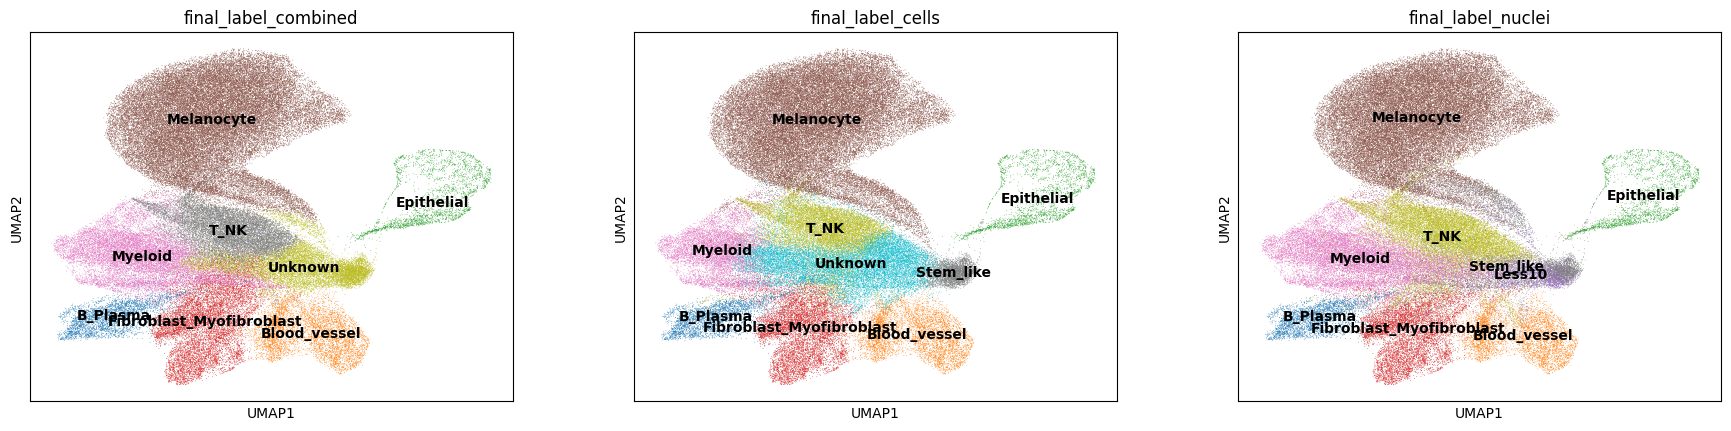

In [47]:
sc.pl.umap(sdata_final.tables['table_combined'], color=['final_label_combined', 'final_label_cells', 'final_label_nuclei'], ncols=3, legend_loc='on data')

In [48]:
# Put table_combined as annotating cell_boundaries

sdata_final["table_combined"].obs["region"] = "cell_boundaries"
sdata_final.tables["table_combined"].obs['region'] = sdata_final.tables["table_combined"].obs['region'].astype('category')
sdata_final.set_table_annotates_spatialelement(table_name="table_combined", region="cell_boundaries", region_key="region", instance_key="cell_id")

region, region_key, instance_key = get_table_keys(sdata_final["table_combined"])
print(region, region_key, instance_key)

cell_boundaries region cell_id


In [49]:
# Color for final label in Napari

to_hex = partial(colors.to_hex, keep_alpha=True)

# Normalize the RGB values to the range [0, 1] by dividing by 255
napari_color = {
                "T_NK": to_hex(to_rgba([255/255, 15/255, 15/255])[:3]),                      # Red
                "B_Plasma": to_hex(to_rgba([255/255, 143/255, 15/255])[:3]),                 # Orange
                "Myeloid": to_hex(to_rgba([255/255, 211/255, 15/255])[:3]),                  # Yellow
                "Blood_vessel": to_hex(to_rgba([70/255, 128/255, 0/255])[:3]),               # Dark Green
                "Fibroblast_Myofibroblast": to_hex(to_rgba([156/255, 255/255, 36/255])[:3]), # Light Green
                "Epithelial": to_hex(to_rgba([57/255, 208/255, 133/255])[:3]),               # Blue Green
                "Specialized": to_hex(to_rgba([69/255, 237/255, 255/255])[:3]),              # Turquoise
                "Melanocyte": to_hex(to_rgba([22/255, 169/255, 223/255])[:3]),               # Blue
                "Stem_like": to_hex(to_rgba([22/255, 69/255, 223/255])[:3]),                 # Dark Blue
                "Glioblastoma": to_hex(to_rgba([130/255, 55/255, 235/255])[:3]),             # Purple
                "Unknown": to_hex(to_rgba([0/255, 0/255, 0/255])[:3]),                       # Black
                "Less10": to_hex(to_rgba([143/255, 143/255, 143/255])[:3])                   # Grey
                }

sdata_final.tables['table_combined'].uns["final_label_combined_colors"] = napari_color
sdata_final.tables['table_combined'].uns["final_label_cells_colors"] = napari_color
sdata_final.tables['table_combined'].uns["final_label_nuclei_colors"] = napari_color

In [50]:
sdata_final.write_element("table_combined")